In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy
import tensorflow as tf

K.set_image_data_format('channels_last')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    return loss

def unet_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true,y_pred) - K.log(jaccard_coef(y_true,y_pred))
    return loss

In [3]:
def applyingclahe(image,leng,wid):
#     gray = image
#     gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
#     ret, gray = cv2.threshold(gray, 250, 255,0)
#     image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     largest_areas = sorted(contours, key=cv2.contourArea)
#     x,y,w,h = cv2.boundingRect(largest_areas[-1])
#     mask = np.zeros((512,512),dtype= np.uint8)
#     cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
#     image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
#     roi=image[y-20:y+h+20,x-20:x+w+20]
#     roi=cv2.resize(roi,(512,512))
    #plt.imshow(roi)
    #plt.show()
    roi = image

    lab= cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    #plt.imshow(lab)
    #plt.show()
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    #plt.imshow(l)
    #plt.show()

    #plt.imshow(a)
    #plt.show()

    #plt.imshow(b)

    #plt.show()
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    #plt.imshow( cl)
    #plt.show()
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    #plt.imshow(limg)
    #plt.show()
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    ori = cv2.resize(image, (leng, wid))
    labimg = cv2.resize(lab, (leng, wid))
    imge = cv2.resize(final, (leng, wid))
    fig = plt.figure(figsize=(50, 50))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(ori)
    plt.title('Original image',fontsize=26)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(labimg)
    plt.title('LAB Colourspace',fontsize=26)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(imge)
    #axarr[1,2].imshow(labimg)
    #axarr[1,3].imshow(imge)
    plt.title('CLAHE Processed image',fontsize=26)
    plt.show()
    return final

In [4]:
from keras.models import load_model
from custom_losses import dice_hard
from capsule_layers import ConvCapsuleLayer, DeconvCapsuleLayer, Mask, Length

mo = load_model('segcaps_final.h5',custom_objects={'ConvCapsuleLayer':ConvCapsuleLayer,'DeconvCapsuleLayer':DeconvCapsuleLayer,'Length':Length,'Mask':Mask,'dice_hard':dice_hard})

In [9]:
from keras.models import load_model
from custom_losses import dice_hard
from capsule_layers import ConvCapsuleLayer, DeconvCapsuleLayer, Mask, Length

mo_unet = load_model('segcaps_final_unetloss_final.h5',custom_objects={'ConvCapsuleLayer':ConvCapsuleLayer,'DeconvCapsuleLayer':DeconvCapsuleLayer,'Length':Length,'Mask':Mask,'dice_hard':dice_hard,'unet_loss':unet_loss})

In [10]:
model = load_model('unet_final.h5', custom_objects={'unet_loss': unet_loss})

In [15]:
def preprocessmask(gray):
    ret, gray = cv2.threshold(gray, 250, 255,0)
    imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_areas = sorted(contours, key=cv2.contourArea)
        print(largest_areas)
        #x,y,w,h = cv2.boundingRect(largest_areas[-1])
        mask = np.zeros((512,512),dtype= np.uint8)
        cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
        return mask
    else:
        return gray
    

def rotate(degree,orig_images):
    rows,cols,_ = orig_images.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degree,1)
    orig_images = cv2.warpAffine(orig_images,M,(cols,rows))
    return orig_images

def cleaned(chosenmodel,orig_images):
    image = np.expand_dims(orig_images, axis=0)
    global model,mo
    if(chosenmodel == 'unet'):
        po = model.predict(image)
    elif(chosenmodel == 'segunet'):
        po = mo_unet.predict(image)
    else:
        po = mo.predict(image)
    po = np.resize(po,(512,512))
    a = np.uint8(po*255)
    a = a.reshape(512,512)
    ret, gray = cv2.threshold(a, 250, 255,0)
    image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_areas = sorted(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(largest_areas[-1])
        mask = np.zeros((512,512),dtype= np.uint8)
        cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
        image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
        roi=image[y-20:y+h+20,x-20:x+w+20]
        roi=cv2.resize(roi,(512,512))
    else:
        extract = cv2.bitwise_and(orig_images, orig_images, mask=gray)
        roi = extract
#     largest_areas = sorted(contours, key=cv2.contourArea)
#     x,y,w,h = cv2.boundingRect(largest_areas[-1])
#     mask = np.zeros((512,512),dtype= np.uint8)
#     cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
#     image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
#     roi=image[y-20:y+h+20,x-20:x+w+20]
#     roi=cv2.resize(roi,(512,512))
    return roi, gray

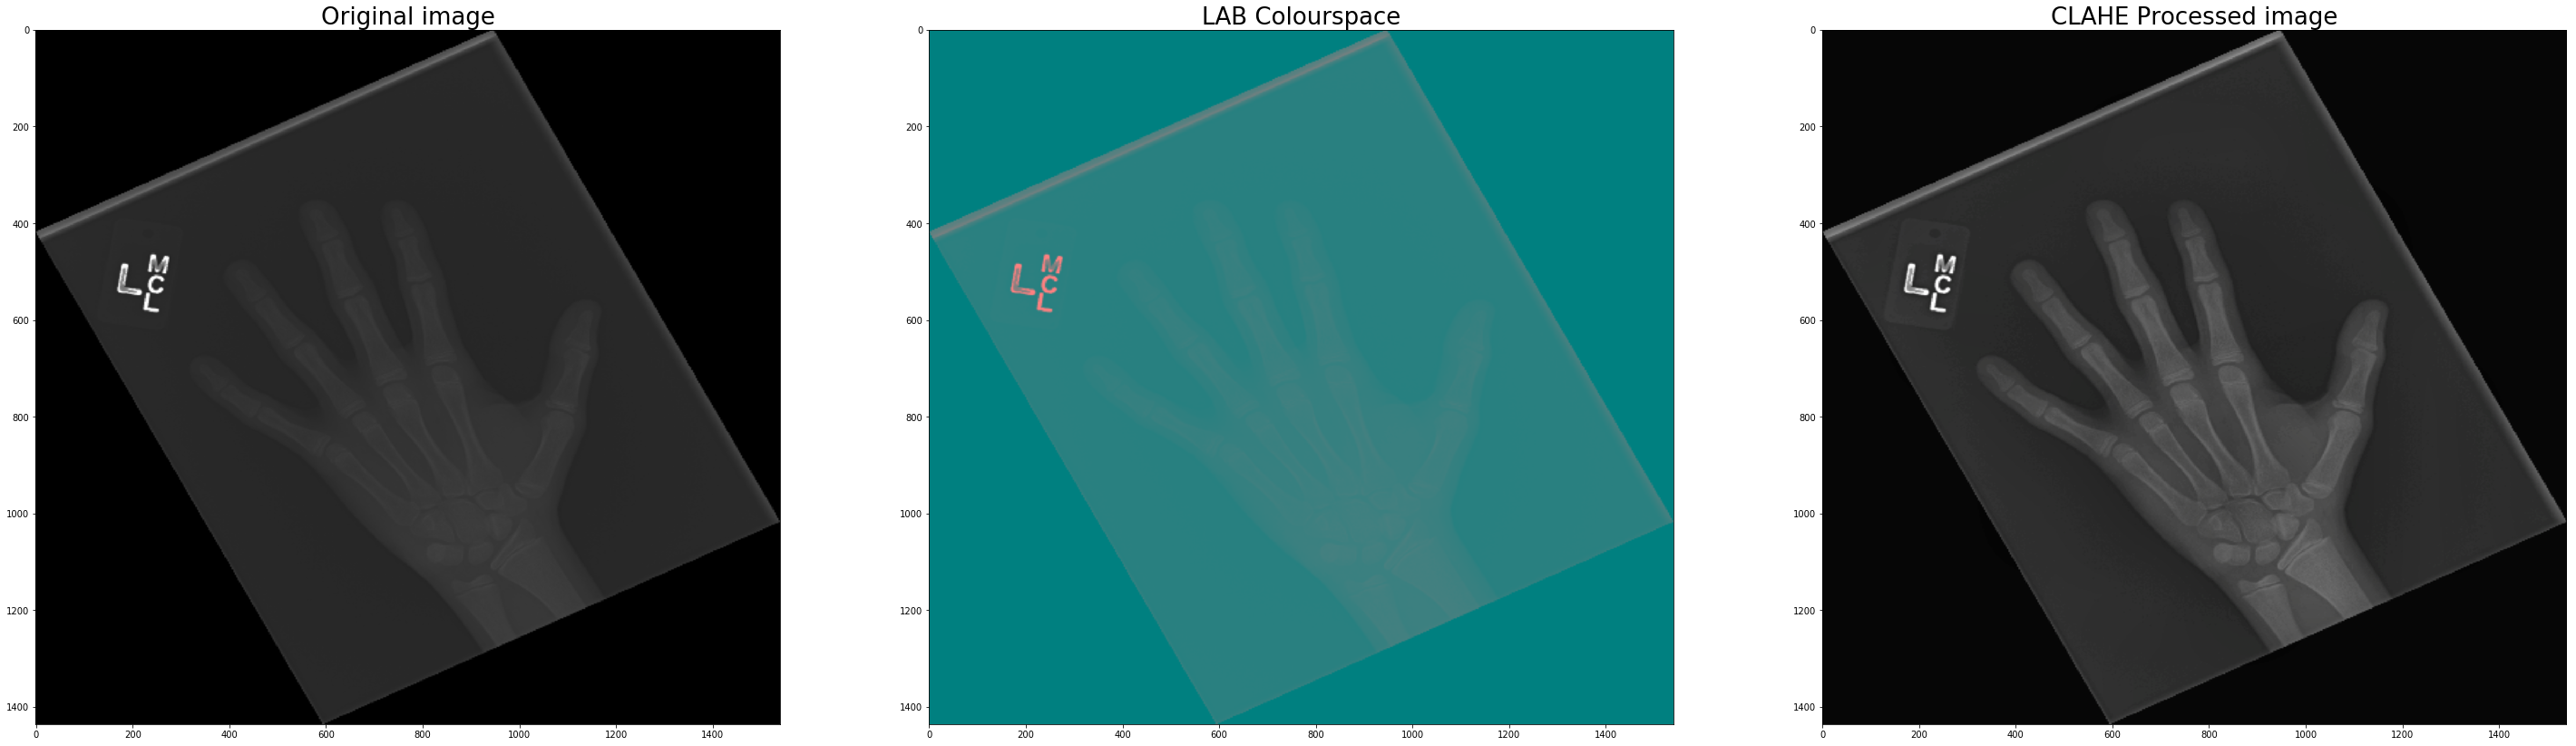

In [42]:
orig_images= cv2.imread("/home/ubuntu/research/train/validation/boneage-validation/3117.png")#4117 #1397
l,w,_ = orig_images.shape
orig_images = cv2.resize(orig_images, (512, 512))
#orig_images = rotate(55,orig_images)
sdd = applyingclahe(orig_images,l,w)

In [43]:
orig_images.shape

(512, 512, 3)

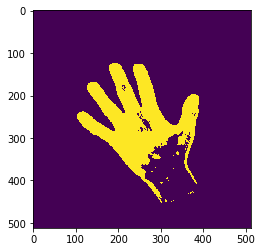

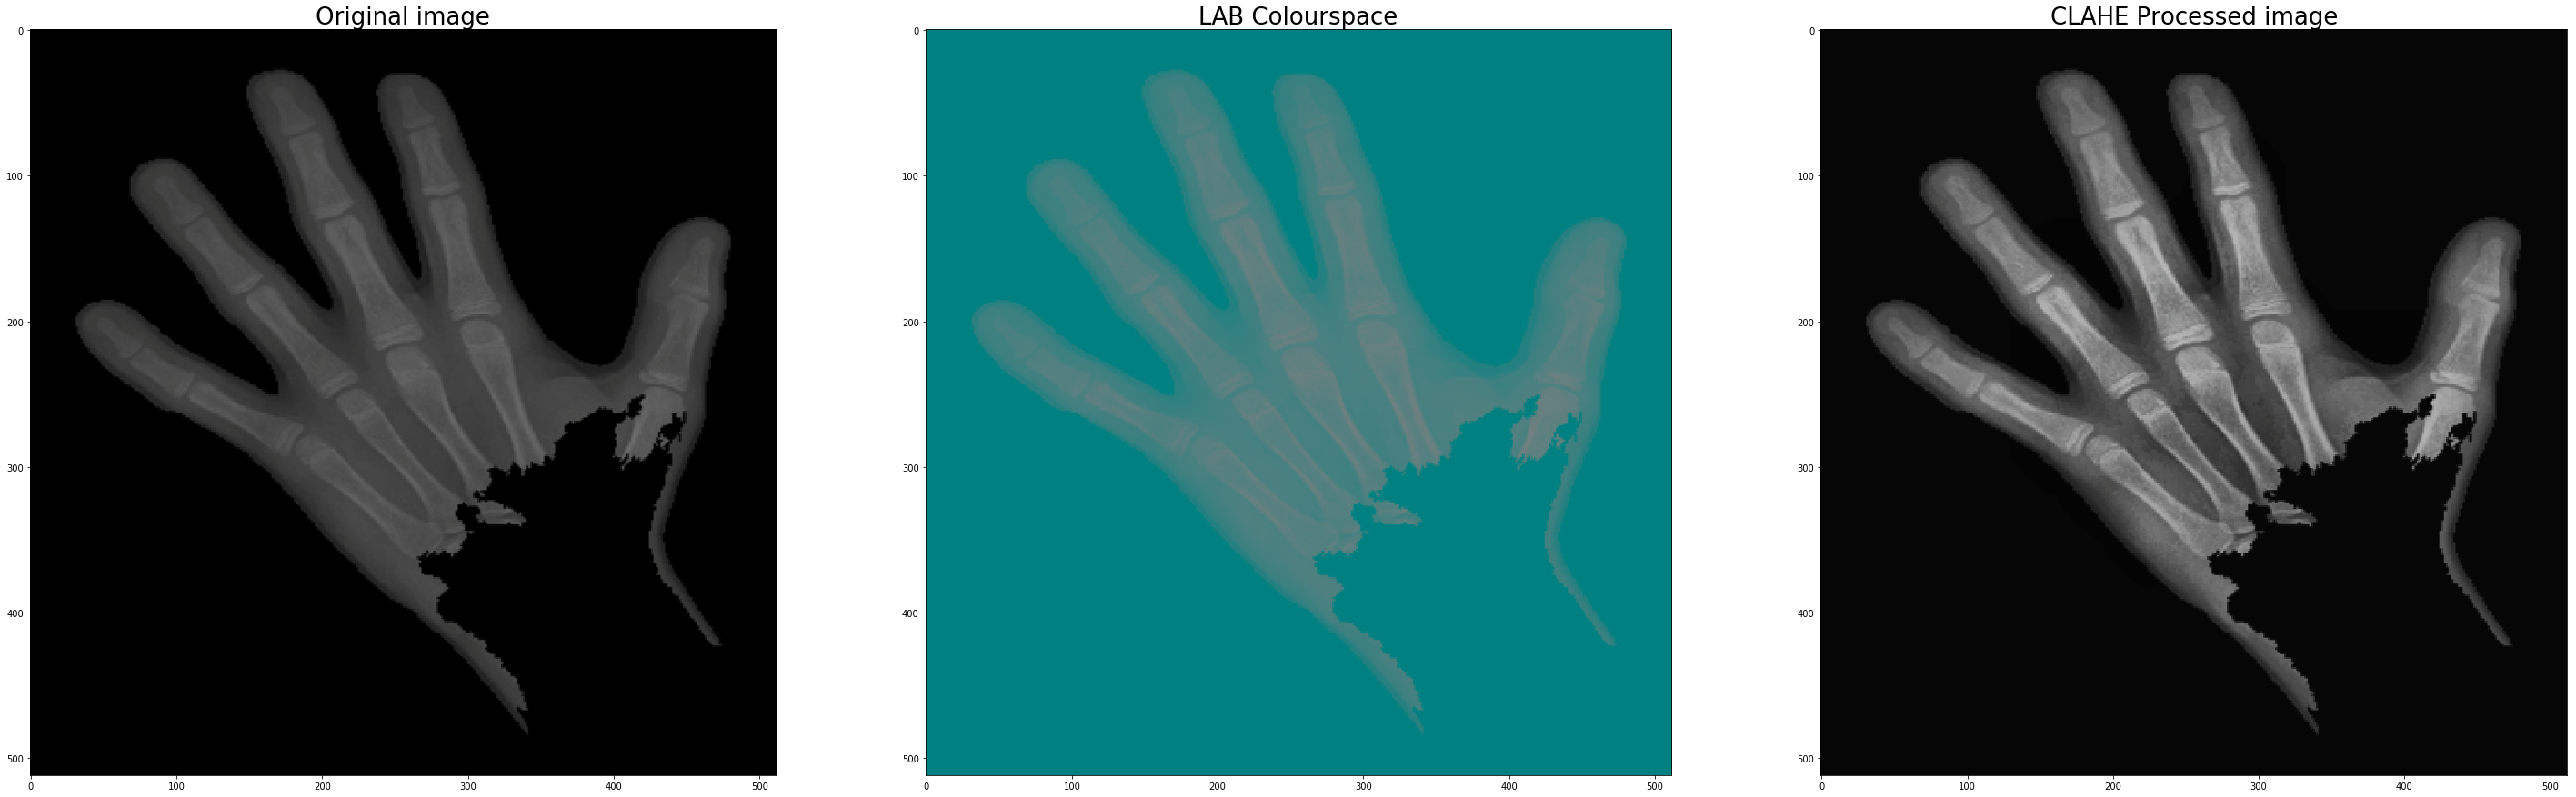

In [44]:
#unet
roi,gray = cleaned('unet',sdd)
plt.imshow(gray)
plt.show()
l,w,_ = roi.shape
final = applyingclahe(roi,l,w)


[array([[[299, 445]]], dtype=int32), array([[[ 57, 257]]], dtype=int32), array([[[133, 180]]], dtype=int32), array([[[228, 312]],

       [[229, 311]],

       [[230, 312]],

       [[229, 313]]], dtype=int32), array([[[227, 310]],

       [[228, 309]],

       [[229, 310]],

       [[229, 311]],

       [[228, 312]],

       [[227, 311]]], dtype=int32), array([[[185, 129]],

       [[184, 130]],

       [[182, 130]],

       ...,

       [[192, 129]],

       [[191, 130]],

       [[190, 129]]], dtype=int32)]


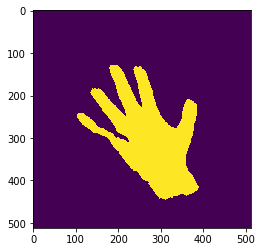

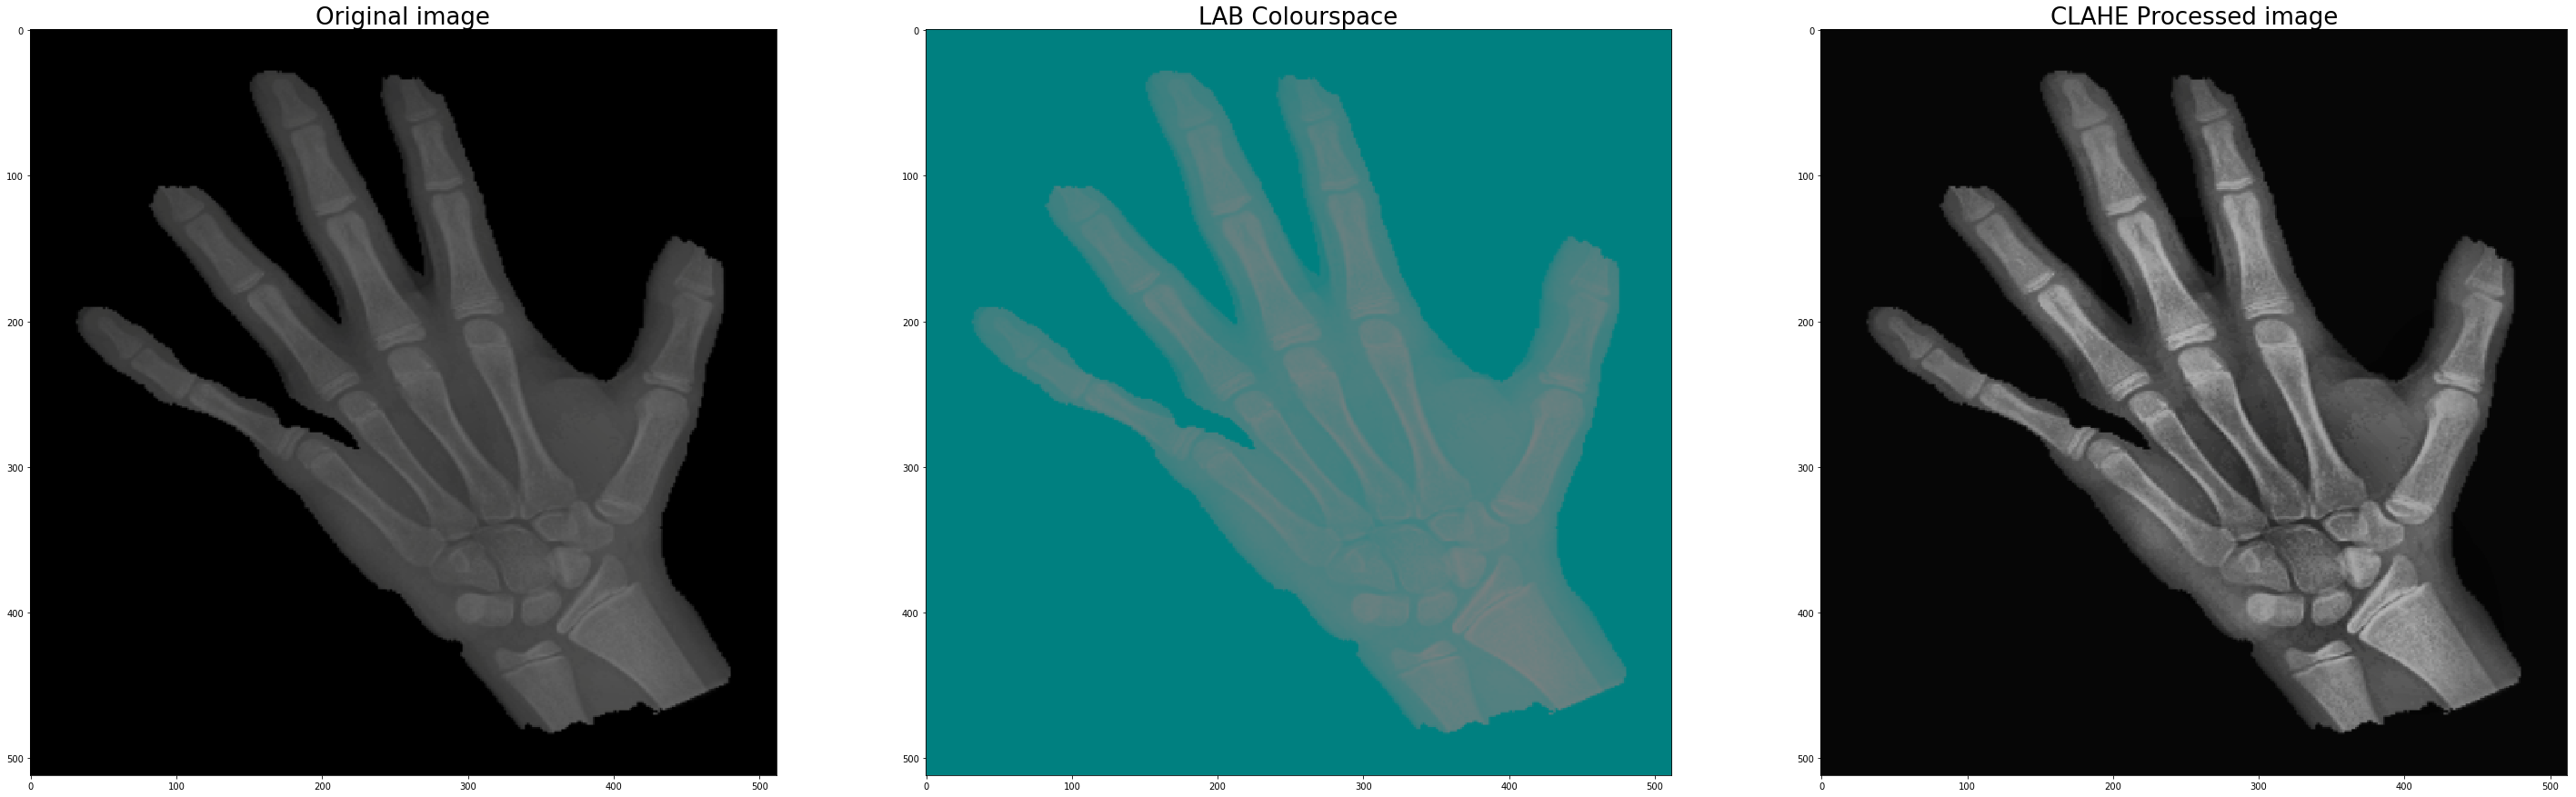

In [45]:
#capsule net

roi,gray = cleaned('capsnet',sdd)
gray = preprocessmask(gray);
plt.imshow(gray)
plt.show()
l,w,_ = roi.shape
final = applyingclahe(roi,l,w)

[array([[[325, 398]],

       [[326, 397]],

       [[327, 398]],

       [[326, 399]]], dtype=int32), array([[[323, 399]],

       [[324, 398]],

       [[325, 398]],

       [[326, 399]],

       [[325, 400]],

       [[324, 400]]], dtype=int32), array([[[326, 395]],

       [[327, 394]],

       [[328, 394]],

       [[329, 395]],

       [[328, 396]],

       [[328, 397]],

       [[327, 398]],

       [[326, 397]]], dtype=int32), array([[[318, 400]],

       [[319, 400]],

       [[320, 401]],

       [[322, 401]],

       [[324, 403]],

       [[324, 406]],

       [[323, 407]],

       [[323, 411]],

       [[324, 412]],

       [[324, 413]],

       [[325, 414]],

       [[325, 418]],

       [[326, 419]],

       [[326, 426]],

       [[325, 427]],

       [[323, 425]],

       [[323, 423]],

       [[322, 422]],

       [[322, 421]],

       [[321, 420]],

       [[321, 416]],

       [[320, 415]],

       [[320, 414]],

       [[319, 413]],

       [[319, 411]],

       [[31

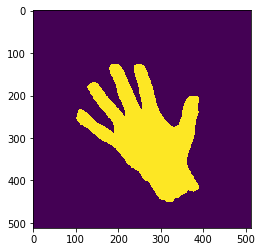

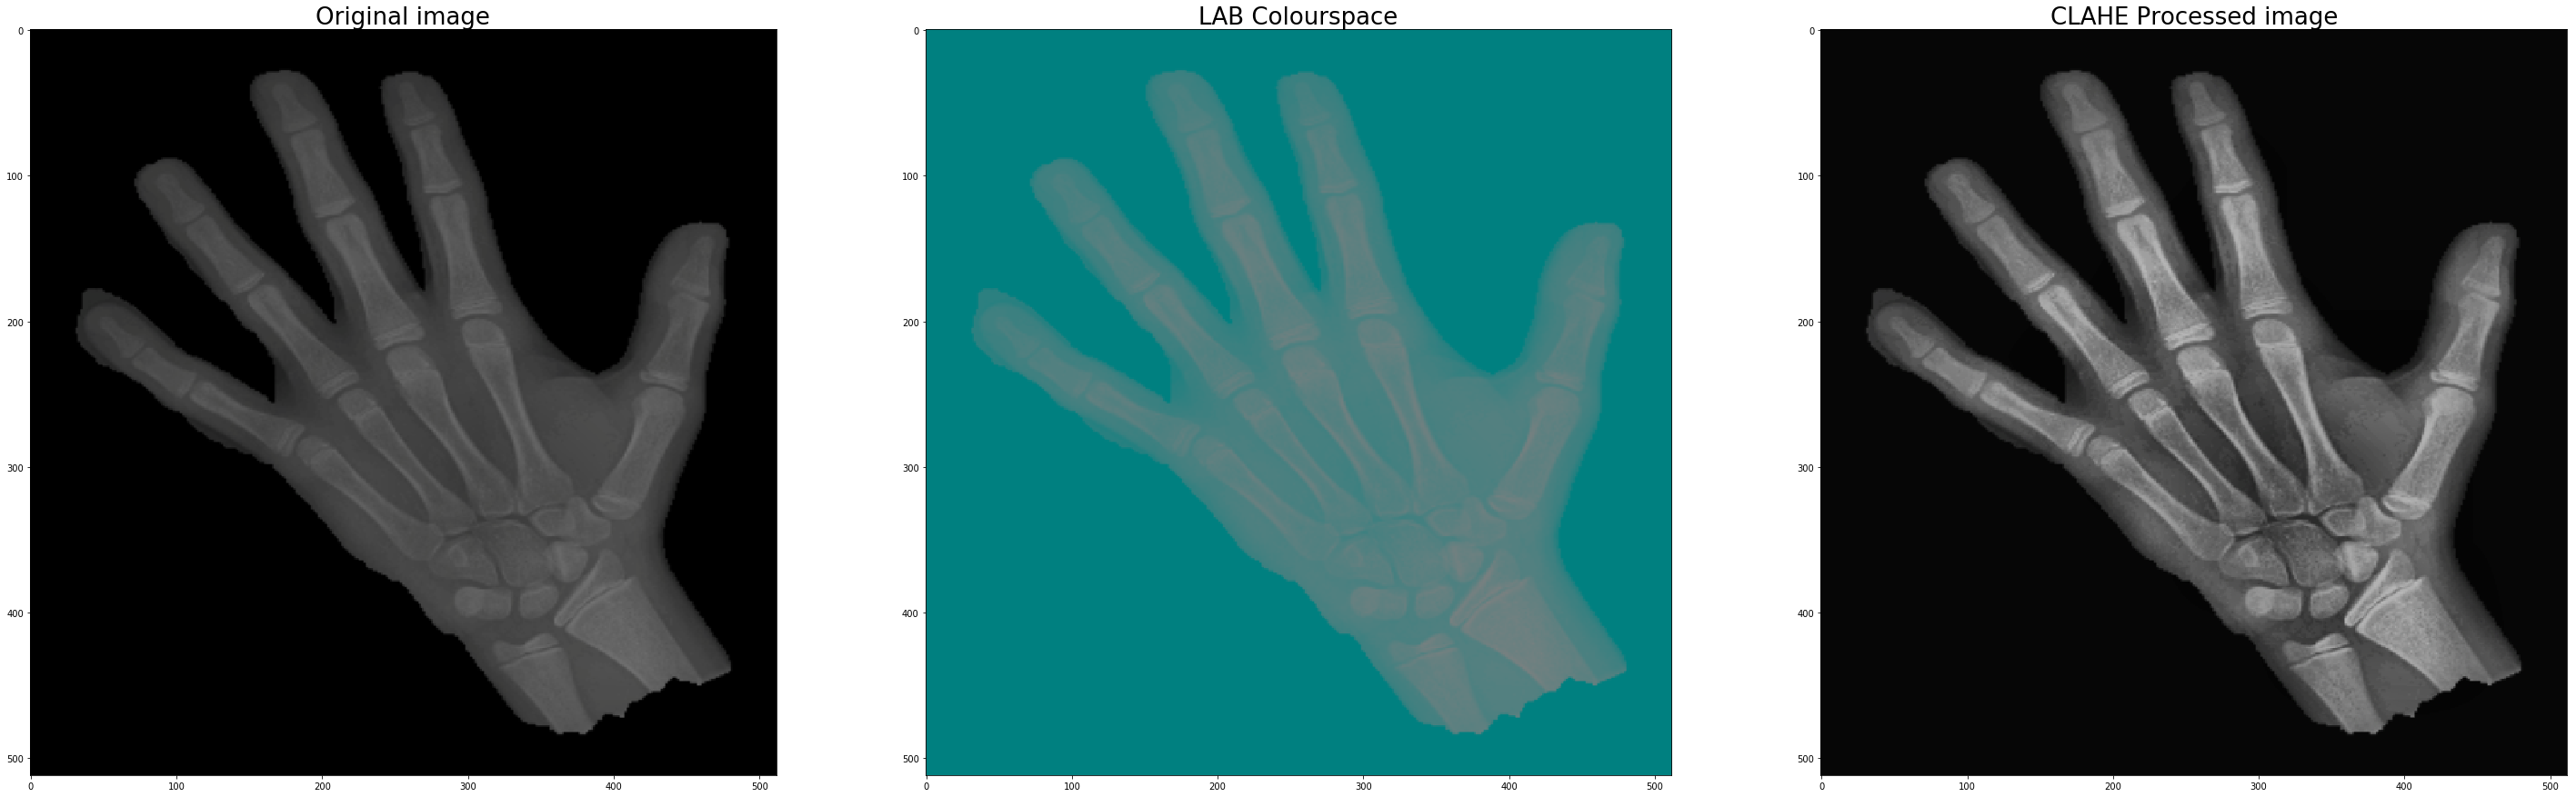

In [46]:
#seg unet capsule net

roi,gray = cleaned('segunet',sdd)
gray = preprocessmask(gray);
plt.imshow(gray)
plt.show()
l,w,_ = roi.shape
final = applyingclahe(roi,l,w)

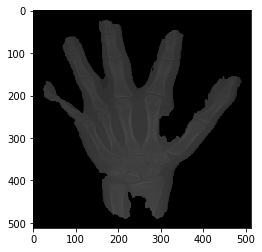

In [16]:
#capsule net
image = np.expand_dims(orig_images, axis=0)
mpo = mo.predict(image)
mpo = np.resize(mpo,(512,512))
b = np.uint8(mpo*255)
b = b.reshape(512,512)
# retval, threshold = cv2.threshold(b, 150, 1, cv2.THRESH_BINARY)

# plt.imshow(threshold)
# #plt.imshow(np.resize(mpo,(512,512)))
ret, gray = cv2.threshold(b, 250, 255,0)
image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_areas[-1])
mask = np.zeros((512,512),dtype= np.uint8)
cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
roi=image[y-20:y+h+20,x-20:x+w+20]
roi=cv2.resize(roi,(512,512))
# rows,cols,_ = roi.shape

# M = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
# orig_images = cv2.warpAffine(roi,M,(cols,rows))
# plt.imshow(orig_images)
plt.imshow(roi)
plt.show()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

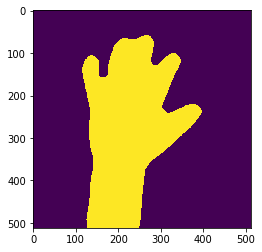

In [13]:
def remove_noise(gray, num):
    Y, X = gray.shape
    nearest_neigbours = [[
        np.argmax(
            np.bincount(
                gray[max(i - num, 0):min(i + num, Y), max(j - num, 0):min(j + num, X)].ravel()))
        for j in range(X)] for i in range(Y)]
    result = np.array(nearest_neigbours, dtype=np.uint8)
    plt.imshow(result)
    return result

remove_noise(threshold, 17)

In [122]:
im_floodfill = threshold.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = threshold.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = threshold | im_floodfill_inv
 


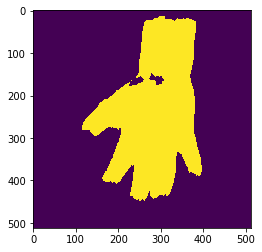

In [127]:
plt.imshow(threshold)

In [144]:
kernel = np.ones((5,5),np.uint8)
    
#closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
dilation = cv2.dilate(threshold,kernel,iterations = 2)

In [147]:
plt.imshow(preprocessmask(dilation))

IndexError: list index out of range

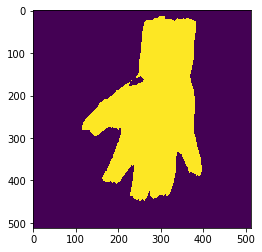

In [126]:
plt.imshow(im_out)

In [155]:
b = preprocessmask(threshold)
plt.imshow(b)

[]


IndexError: list index out of range

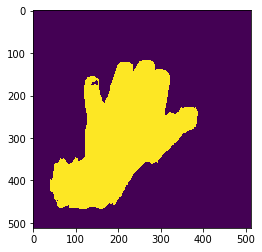

In [159]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    plt.imshow(img2)
    return img2
h = undesired_objects(threshold)

array([  0, 255], dtype=uint8)

In [75]:
def mask_overlay(image, mask, color=(0, 255, 255)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    return cv2.addWeighted(mask, 0.5, image, 0.5, 0.)

In [164]:
#final_overlay = mask_overlay(orig_images, (h > 0.5).astype(np.uint8))
#new_image = cv2.bitwise_and(final_overlay, final_overlay, mask = equalize)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
c=contours[0]
new_image = cv2.drawContours(h,[c], -1, (255,255,255), -1)
new_image_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
new,contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ret, thresh1 = cv2.threshold(new_image_gray, 100, 255, cv2.THRESH_BINARY)
final = cv2.bitwise_and(orig_images, orig_images, mask = thresh1)
plt.imshow(final)

error: /io/opencv/modules/imgproc/src/color.cpp:11073: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cvtColor
